In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, add, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from utils import *


## Data Loading

### Raw Data

In [43]:
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=True)

### Data Augmentation

In [44]:
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=True)
x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

Training data shape: (7616, 22, 250) Training target shape: (7616,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
Training data shape: (7616, 250, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 250, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 250, 1, 22) Testing target shape: (443, 4)


### Data CWT

In [45]:
X_train, y_train, X_test, y_test = init_data(subject=None)
X_train, y_train, X_test, y_test, X_valid, y_valid = preprocess_data(X_train, y_train, X_test, y_test, verbose=True)

scales = np.arange(1, 7)

X_train_cwt = cwt_transform(X_train, scales, ricker, verbose=True)
X_valid_cwt = cwt_transform(X_valid, scales, ricker, verbose=True)
X_test_cwt = cwt_transform(X_test, scales, ricker, verbose=True)

# X_train_cwt, y_train_cwt, X_test_cwt, y_test_cwt, X_valid_cwt, y_valid_cwt= preprocess_data(X_train_cwt, y_train, X_test_cwt, y_test, verbose=True)
# X_train_cwt, y_train_cwt, X_valid_cwt, y_valid_cwt, X_test_cwt, y_test_cwt = load_data(X_train_cwt, y_train_cwt, X_valid_cwt, y_valid_cwt, X_test_cwt, y_test_cwt, verbose=True)



y_train_cwt = to_categorical(y_train, 4)
y_valid_cwt = to_categorical(y_valid, 4)
y_test_cwt = to_categorical(y_test, 4)

x_train_cwt = np.swapaxes(X_train_cwt, 1, 3)
x_valid_cwt = np.swapaxes(X_valid_cwt, 1, 3)
x_test_cwt = np.swapaxes(X_test_cwt, 1, 3)


Training data shape: (7616, 22, 250) Training target shape: (7616,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
CWT Transformed data shape: (7616, 22, 6, 250)
CWT Transformed data shape: (844, 22, 6, 250)
CWT Transformed data shape: (443, 22, 6, 250)


## MaxPool_CNN_v2 w/Residual block

### Train with Aug Data

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, add, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def residual_block(X, filters, dropout, kernel_size=(4,1), adjust_filters=False):
    X_shortcut = X

    # If needed, adjust the number of filters in the shortcut path
    if adjust_filters:
        X_shortcut = Conv2D(filters=filters, kernel_size=(1,1), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)  # It's a good practice to include BatchNormalization

    # First component of the main path
    X = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='elu',kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)

    # Second component of the main path
    X = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)
    # Add shortcut value to main path, and pass it through a RELU activation
    X = add([X, X_shortcut])
    X = Activation('elu')(X)

    return X

early_stop = EarlyStopping(monitor='val_loss', # Value to monitor
                           patience=7,         # How many epochs to wait after min has been hit
                           verbose=1,          # Logging level
                           mode='min',         # The direction is automatically inferred from the name of the monitored quantity
                           restore_best_weights=True) # Whether to restore model weights from the epoch with the best value of the monitored quantity

dropout = 0.55
learning_rate = 0.0003
weight_decay = 0.03
epochs = 100

input_shape = (250,1,22)

# Define the input as a tensor with shape input_shape
X_input = Input(input_shape)

# Initial Convolution and MaxPooling
X = Conv2D(filters=22, kernel_size=(4,1), padding='same', activation='elu', input_shape=input_shape, kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X_input)
X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
X = BatchNormalization()(X)
X = Dropout(dropout)(X)

# Incorporating Residual Blocks
X = residual_block(X, 44, dropout, adjust_filters=True)
X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)

X = residual_block(X, 88, dropout, adjust_filters=True)
X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)

# Output layer
X = Flatten()(X)
X = Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)

# Create model
resmodel = Model(inputs=X_input, outputs=X, name='ResNetCNN')

resmodel.summary()

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
optimizer = Adam(lr=learning_rate)
resmodel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
results = resmodel.fit(x_train_aug,
                  y_train_aug,
                  batch_size=64,
                  epochs=epochs,
                  validation_data=(x_valid_aug, y_valid_aug), callbacks=[early_stop, lr_callback], verbose=1)


Model: "ResNetCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 250, 1, 22)] 0                                            
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 250, 1, 22)   1958        input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 125, 1, 22)   0           conv2d_86[0][0]                  
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 125, 1, 22)   88          max_pooling2d_38[0][0]           
__________________________________________________________________________________________

In [47]:
score = resmodel.evaluate(x_test_aug, y_test_aug, verbose=0)
print(f'Test accuracy:{score[1]}')

Test accuracy:0.7336342930793762


### Train with CWT data

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, add, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def residual_block(X, filters, dropout, kernel_size=(4,1), adjust_filters=False):
    X_shortcut = X

    # If needed, adjust the number of filters in the shortcut path
    if adjust_filters:
        X_shortcut = Conv2D(filters=filters, kernel_size=(1,1), padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)  # It's a good practice to include BatchNormalization

    # First component of the main path
    X = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='elu',kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)

    # Second component of the main path
    X = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)
    # Add shortcut value to main path, and pass it through a RELU activation
    X = add([X, X_shortcut])
    X = Activation('elu')(X)

    return X

early_stop = EarlyStopping(monitor='val_loss', # Value to monitor
                           patience=7,         # How many epochs to wait after min has been hit
                           verbose=1,          # Logging level
                           mode='min',         # The direction is automatically inferred from the name of the monitored quantity
                           restore_best_weights=True) # Whether to restore model weights from the epoch with the best value of the monitored quantity

dropout = 0.55
learning_rate = 0.001
weight_decay = 0.03
epochs = 25

input_shape = (250,6,22)

# Define the input as a tensor with shape input_shape
X_input = Input(input_shape)

# Initial Convolution and MaxPooling
X = Conv2D(filters=22, kernel_size=(4,1), padding='same', activation='elu', input_shape=input_shape, kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X_input)
X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
X = BatchNormalization()(X)
X = Dropout(dropout)(X)

# Incorporating Residual Blocks
X = residual_block(X, 44, dropout, adjust_filters=True)
X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)

# Output layer
X = Flatten()(X)
X = Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)

# Create model
resmodel = Model(inputs=X_input, outputs=X, name='ResNetCNN')

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
optimizer = Adam(lr=learning_rate)
resmodel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
results = resmodel.fit(x_train_cwt,
                  y_train_cwt,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid_cwt, y_valid_cwt), callbacks=[lr_callback, early_stop], verbose=1)


Epoch 1/25
238/238 [==============================] - 18s 74ms/step - loss: 9.4980 - accuracy: 0.3755 - val_loss: 6.4475 - val_accuracy: 0.4325
Epoch 2/25
238/238 [==============================] - 17s 69ms/step - loss: 5.4742 - accuracy: 0.5076 - val_loss: 4.1849 - val_accuracy: 0.4882
Epoch 3/25
238/238 [==============================] - 16s 68ms/step - loss: 3.4896 - accuracy: 0.6226 - val_loss: 3.2367 - val_accuracy: 0.4645
Epoch 4/25
238/238 [==============================] - 16s 68ms/step - loss: 2.4990 - accuracy: 0.6847 - val_loss: 2.6313 - val_accuracy: 0.5213
Epoch 5/25
238/238 [==============================] - 16s 68ms/step - loss: 1.9155 - accuracy: 0.7274 - val_loss: 2.4076 - val_accuracy: 0.4775
Epoch 6/25
238/238 [==============================] - 16s 68ms/step - loss: 1.6179 - accuracy: 0.7441 - val_loss: 2.1373 - val_accuracy: 0.5059
Epoch 7/25
238/238 [==============================] - 16s 69ms/step - loss: 1.4398 - accuracy: 0.7528 - val_loss: 2.0758 - val_accuracy:

In [49]:
score = resmodel.evaluate(x_test_cwt, y_test_cwt, verbose=0)
print(f'Test accuracy:{score[1]}')

Test accuracy:0.5395033955574036


## Train based on subjects (Use Aug data since better generalization)

In [60]:
acc_subjects = []
acc_subject_v_all = []
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False)
_, _, _, _, x_test_aug_all, y_test_aug_all = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)

for i in range(9):
    X_train, y_train, X_test, y_test = init_data(subject=i, verbose=False)
    X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False)
    x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)

    early_stop = EarlyStopping(monitor='val_loss', 
                           patience=7,        
                           verbose=1,         
                           mode='min',        
                           restore_best_weights=True)

    dropout = 0.55
    learning_rate = 0.0003
    weight_decay = 0.03
    epochs = 100
    
    input_shape = (250,1,22)
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Initial Convolution and MaxPooling
    X = Conv2D(filters=22, kernel_size=(4,1), padding='same', activation='elu', input_shape=input_shape, kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X_input)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)
    
    # Incorporating Residual Blocks
    X = residual_block(X, 44, dropout, adjust_filters=True)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
    
    X = residual_block(X, 88, dropout, adjust_filters=True)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)
    
    # Create model
    resmodel = Model(inputs=X_input, outputs=X, name='ResNetCNN')

    
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    
    resmodel.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    
    results = resmodel.fit(x_train_aug,
                y_train_aug,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_aug, y_valid_aug), callbacks=[early_stop, lr_callback], verbose=0)

    score = resmodel.evaluate(x_test_aug, y_test_aug, verbose=0)
    print(f'Test accuracy for subject {i}: {score[1]}')
    acc_subjects.append(score[1])

    score = resmodel.evaluate(x_test_aug_all, y_test_aug_all, verbose=0)
    print(f'Test accuracy for subject {i} to all data: {score[1]}')
    acc_subject_v_all.append(score[1])

print(acc_subjects)
print(acc_subject_v_all)
        

Test accuracy for subject 0: 0.3400000035762787
Test accuracy for subject 0 to all data: 0.3386004567146301
Test accuracy for subject 1: 0.47999998927116394
Test accuracy for subject 1 to all data: 0.3724604845046997
Test accuracy for subject 2: 0.4399999976158142
Test accuracy for subject 2 to all data: 0.32505643367767334
Test accuracy for subject 3: 0.5600000023841858
Test accuracy for subject 3 to all data: 0.3837471902370453
Test accuracy for subject 4: 0.6595744490623474
Test accuracy for subject 4 to all data: 0.4040631949901581
Test accuracy for subject 5: 0.5102040767669678
Test accuracy for subject 5 to all data: 0.2866817116737366
Test accuracy for subject 6: 0.5799999833106995
Test accuracy for subject 6 to all data: 0.4063205420970917
Test accuracy for subject 7: 0.46000000834465027
Test accuracy for subject 7 to all data: 0.32054176926612854
Test accuracy for subject 8: 0.40425533056259155
Test accuracy for subject 8 to all data: 0.2731376886367798
[0.3400000035762787, 0.

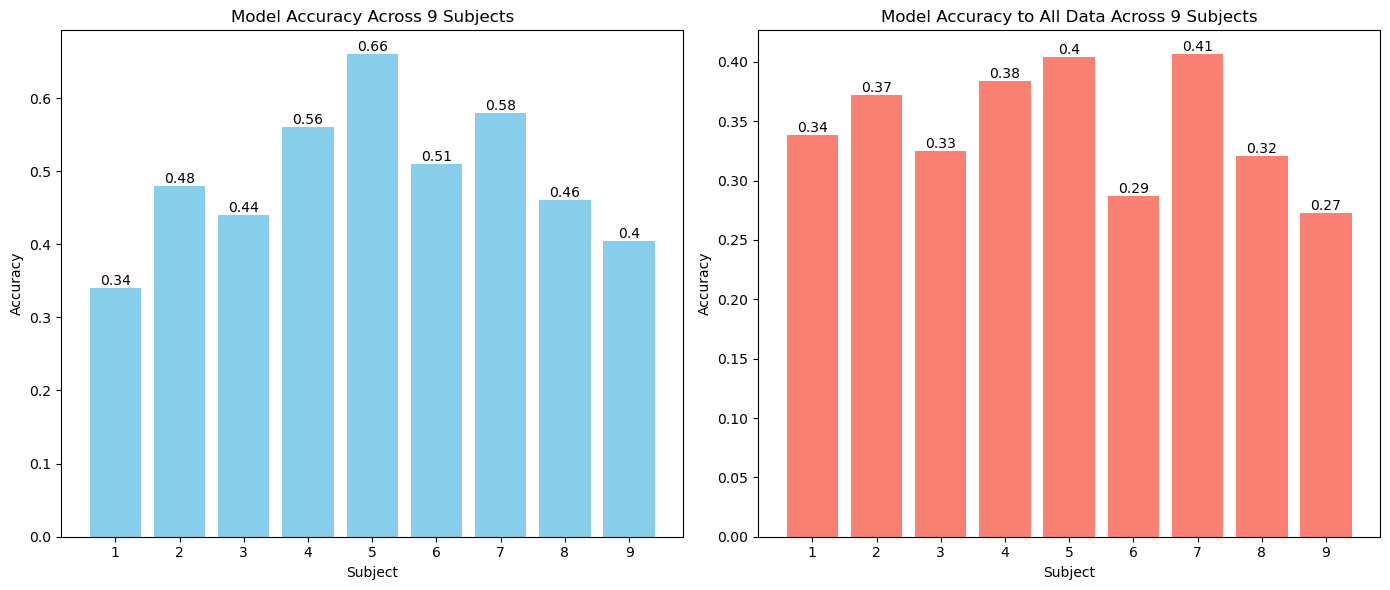

In [61]:
subjects = [i for i in range(1,10)]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
bars = plt.bar(subjects, acc_subjects, color='skyblue')
plt.title('Model Accuracy Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.subplot(1, 2, 2) 
bars = plt.bar(subjects, acc_subject_v_all, color='salmon')
plt.title('Model Accuracy to All Data Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [62]:
acc_timestamps = []
for j in range(100, 1001, 100):
    X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
    ind_valid = np.random.choice(X_train.shape[0], int(0.1 * X_train.shape[0]), replace=False)
    ind_train = np.array(list(set(range(X_train.shape[0])).difference(set(ind_valid))))
    (x_train, x_valid) = X_train[ind_train], X_train[ind_valid]
    (y_train, y_valid) = y_train[ind_train], y_train[ind_valid]

    X_train = x_train[:, :, :j]
    X_valid = x_valid[:, :, :j]
    X_test = X_test[:, :, :j]
    X__train_max = np.max(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 2), axis=3)
    X_test_max = np.max(X_test.reshape(X_test.shape[0], X_test.shape[1], -1, 2), axis=3)
    X_average_train = np.mean(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 2), axis=3)
    X_average_train = X_average_train + np.random.normal(0.0, 0.5, X_average_train.shape)
    X__valid_max = np.max(X_valid.reshape(X_valid.shape[0], X_valid.shape[1], -1, 2), axis=3)
    X_average_valid = np.mean(X_valid.reshape(X_valid.shape[0], X_valid.shape[1], -1, 2), axis=3)
    X_average_valid = X_average_valid + np.random.normal(0.0, 0.5, X_average_valid.shape)
    total_X_train = np.vstack((X__train_max, X_average_train))
    total_y_train = np.hstack((y_train, y_train))
    total_X_valid = np.vstack((X__valid_max, X_average_valid))
    total_y_valid = np.hstack((y_valid, y_valid))
    for i in range(2):
        X_subsample = X_train[:, :, i::2] + np.random.normal(0.0, 0.5, X_train[:, :, i::2].shape)

        total_X_train = np.vstack((total_X_train, X_subsample))
        total_y_train = np.hstack((total_y_train, y_train))

    for i in range(2):
        X_subsample = X_valid[:, :, i::2] + np.random.normal(0.0, 0.5, X_valid[:, :, i::2].shape)
        total_X_valid = np.vstack((total_X_valid, X_subsample))
        total_y_valid = np.hstack((total_y_valid, y_valid))

    x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(total_X_train, total_y_train, total_X_valid, total_y_valid, X_test_max, y_test, verbose=True)

    early_stop = EarlyStopping(monitor='val_loss', 
                           patience=7,        
                           verbose=1,         
                           mode='min',        
                           restore_best_weights=True)

    dropout = 0.55
    learning_rate = 0.0003
    weight_decay = 0.03
    epochs = 100
    
    input_shape = (j//2,1,22)
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Initial Convolution and MaxPooling
    X = Conv2D(filters=22, kernel_size=(4,1), padding='same', activation='elu', input_shape=input_shape, kernel_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X_input)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout)(X)
    
    # Incorporating Residual Blocks
    X = residual_block(X, 44, dropout, adjust_filters=True)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
    
    X = residual_block(X, 88, dropout, adjust_filters=True)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), padding='same')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform')(X)
    
    # Create model
    resmodel = Model(inputs=X_input, outputs=X, name='ResNetCNN')

    
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    
    resmodel.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    
    results = resmodel.fit(x_train_aug,
                y_train_aug,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_aug, y_valid_aug), callbacks=[lr_callback, early_stop], verbose=0)

    score = resmodel.evaluate(x_test_aug, y_test_aug, verbose=0)
    print(f'Test accuracy for timestamp {j}: {score[1]}')
    acc_timestamps.append(score[1])


print(acc_timestamps)


Training data shape: (7616, 50, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 50, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 50, 1, 22) Testing target shape: (443, 4)
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Test accuracy for timestamp 100: 0.5395033955574036
Training data shape: (7616, 100, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 100, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 100, 1, 22) Testing target shape: (443, 4)
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Test accuracy for timestamp 200: 0.6433408856391907
Training data shape: (7616, 150, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 150, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 150, 1, 22) Testing target shape: (443, 4)
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopp

Text(0, 0.5, 'Accuracy')

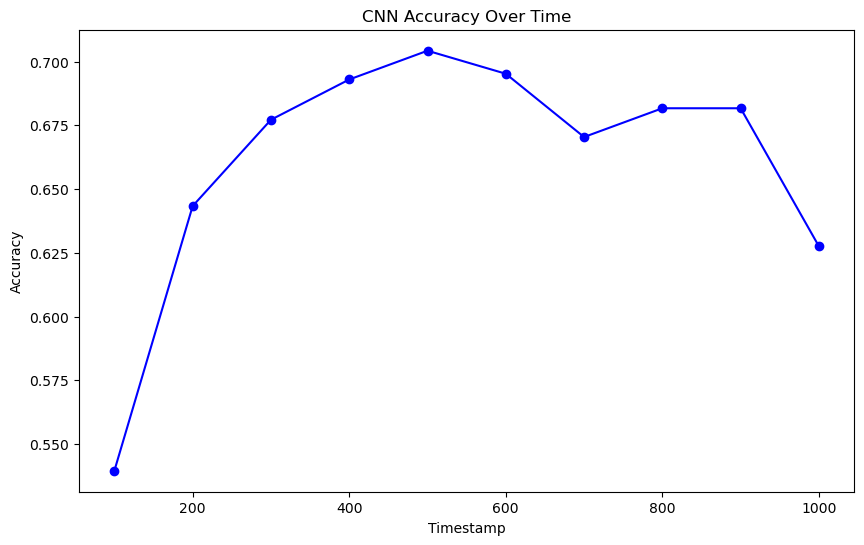

In [63]:
timestamps = [i for i in range(100, 1001, 100)]
plt.figure(figsize=(10, 6))
plt.plot(timestamps, acc_timestamps, marker='o', linestyle='-', color='b')

plt.title('CNN Accuracy Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')